# Part 1 Practice: BPSK and QPSK's SER vs SNR

## Uncoded System

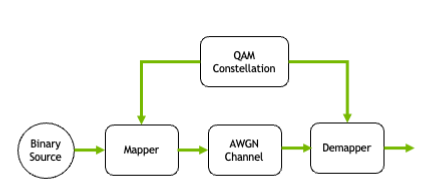

## Coded System

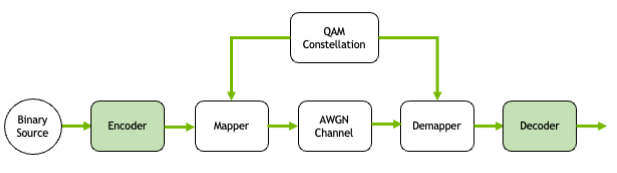

#Part 1: Getting Started with Sionna

In [3]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

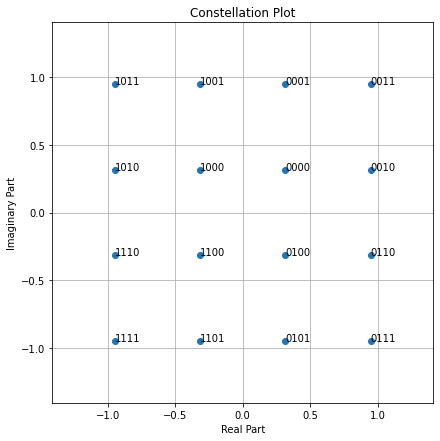

In [4]:
# Constellation

NUM_BITS_PER_SYMBOL = 4 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

constellation.show(figsize=(7,7));

In [5]:
# Mapper and Demapper

mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [6]:
binary_source = sn.utils.BinarySource()

awgn_channel = sn.channel.AWGN()

no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
#print("Shape of bits: ", bits.shape)
#print(bits)

x = mapper(bits)
#print("Shape of x: ", x.shape)
#print("x=",x)

y = awgn_channel([x, no])
#print("Shape of y: ", y.shape)
#print("y=",y)

llr = demapper([y, no])
#print("Shape of llr: ", llr.shape)
#print("llr=",llr)

In [7]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [0. 0. 1. 1. 0. 0. 0. 1.]
First 2 transmitted symbols: [0.95+0.95j 0.32+0.95j]
First 2 received symbols: [1.  +1.03j 0.34+0.68j]
First 8 demapped llrs: [-68.73 -71.74  18.37  19.87 -17.26 -36.71 -14.74   2.31]


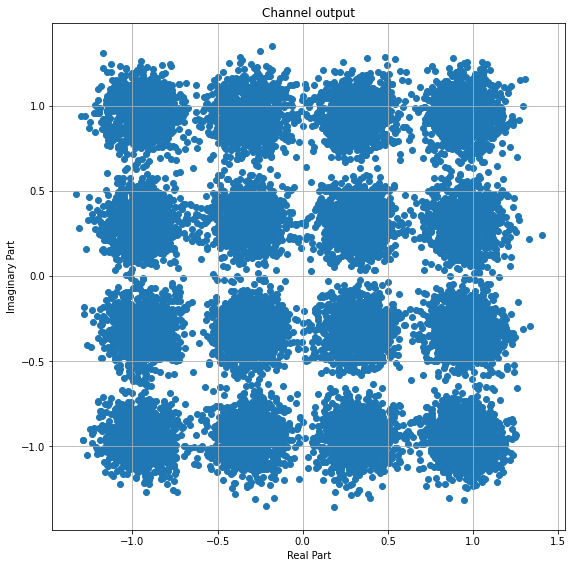

In [8]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

#我是分割线

In [13]:
#
# SPDX-FileCopyrightText: Copyright (c) 2021-2023 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
"""Plotting functions for the Sionna library."""

import numpy as np
import matplotlib.pyplot as plt
from sionna.utils import sim_ber
from itertools import compress # to "filter" list

def plot_ber(snr_db,
             ber,
             legend="",
             ylabel="BER",
             title="Bit Error Rate",
             ebno=True,
             is_bler=None,
             xlim=None,
             ylim=None,
             save_fig=False,
             path=""):
    """Plot error-rates.

    Input
    -----
    snr_db: ndarray
        Array of floats defining the simulated SNR points.
        Can be also a list of multiple arrays.

    ber: ndarray
        Array of floats defining the BER/BLER per SNR point.
        Can be also a list of multiple arrays.

    legend: str
        Defaults to "". Defining the legend entries. Can be
        either a string or a list of strings.

    ylabel: str
        Defaults to "BER". Defining the y-label.

    title: str
        Defaults to "Bit Error Rate". Defining the title of the figure.

    ebno: bool
        Defaults to True. If True, the x-label is set to
        "EbNo [dB]" instead of "EsNo [dB]".

    is_bler: bool
        Defaults to False. If True, the corresponding curve is dashed.

    xlim: tuple of floats
        Defaults to None. A tuple of two floats defining x-axis limits.

    ylim: tuple of floats
        Defaults to None. A tuple of two floats defining y-axis limits.

    save_fig: bool
        Defaults to False. If True, the figure is saved as `.png`.

    path: str
        Defaults to "". Defining the path to save the figure
        (iff ``save_fig`` is True).

    Output
    ------
        (fig, ax) :
            Tuple:

        fig : matplotlib.figure.Figure
            A matplotlib figure handle.

        ax : matplotlib.axes.Axes
            A matplotlib axes object.
    """

    # legend must be a list or string
    if not isinstance(legend, list):
        assert isinstance(legend, str)
        legend = [legend]

    assert isinstance(title, str), "title must be str."

    # broadcast snr if ber is list
    if isinstance(ber, list):
        if not isinstance(snr_db, list):
            snr_db = [snr_db]*len(ber)

    # check that is_bler is list of same size and contains only bools
    if is_bler is None:
        if isinstance(ber, list):
            is_bler = [False] * len(ber) # init is_bler as list with False
        else:
            is_bler = False
    else:
        if isinstance(is_bler, list):
            assert (len(is_bler) == len(ber)), "is_bler has invalid size."
        else:
            assert isinstance(is_bler, bool), \
                "is_bler must be bool or list of bool."
            is_bler = [is_bler] # change to list

    # tile snr_db if not list, but ber is list

    fig, ax = plt.subplots(figsize=(16,10))

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.title(title, fontsize=25)
    # return figure handle
    if isinstance(ber, list):
        for idx, b in enumerate(ber):
            if is_bler[idx]:
                line_style = "--"
            else:
                line_style = ""
            plt.semilogy(snr_db[idx], b, line_style, linewidth=2)
    else:
        if is_bler:
            line_style = "--"
        else:
            line_style = ""
        plt.semilogy(snr_db, ber, line_style, linewidth=2)

    plt.grid(which="both")
    if ebno:
        plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=25)
    else:
        plt.xlabel(r"$E_s/N_0$ (dB)", fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.legend(legend, fontsize=20)
    if save_fig:
        plt.savefig(path)
        plt.close(fig)
    else:
        #plt.close(fig)
        pass
    return fig, ax


###### Plotting classes #######

class PlotBER():
    """Provides a plotting object to simulate and store BER/BLER curves.

    Parameters
    ----------
    title: str
        A string defining the title of the figure. Defaults to
        `"Bit/Block Error Rate"`.

    Input
    -----
    snr_db: float
        Python array (or list of Python arrays) of additional SNR values to be
        plotted.

    ber: float
        Python array (or list of Python arrays) of additional BERs
        corresponding to ``snr_db``.

    legend: str
        String (or list of strings) of legends entries.

    is_bler: bool
        A boolean (or list of booleans) defaults to False.
        If True, ``ber`` will be interpreted as BLER.

    show_ber: bool
        A boolean defaults to True. If True, BER curves will be plotted.

    show_bler: bool
        A boolean defaults to True. If True, BLER curves will be plotted.

    xlim: tuple of floats
        Defaults to None. A tuple of two floats defining x-axis limits.

    ylim: tuple of floats
        Defaults to None. A tuple of two floats defining y-axis limits.

    save_fig: bool
        A boolean defaults to False. If True, the figure
        is saved as file.

    path: str
        A string defining where to save the figure (if ``save_fig``
        is True).
    """

    def __init__(self, title="Bit/Block Error Rate"):

        assert isinstance(title, str), "title must be str."
        self._title = title

        # init lists
        self._bers = []
        self._snrs = []
        self._legends = []
        self._is_bler = []

    # pylint: disable=W0102
    def __call__(self,
                 snr_db=[],
                 ber=[],
                 legend=[],
                 is_bler=[],
                 show_ber=True,
                 show_bler=True,
                 xlim=None,
                 ylim=None,
                 save_fig=False,
                 path=""):
        """Plot BER curves.

        """

        assert isinstance(path, str), "path must be str."
        assert isinstance(save_fig, bool), "save_fig must be bool."

        # broadcast snr if ber is list
        if isinstance(ber, list):
            if not isinstance(snr_db, list):
                snr_db = [snr_db]*len(ber)

        if not isinstance(snr_db, list):
            snrs = self._snrs + [snr_db]
        else:
            snrs = self._snrs + snr_db
        if not isinstance(ber, list):
            bers = self._bers + [ber]
        else:
            bers = self._bers + ber
        if not isinstance(legend, list):
            legends = self._legends + [legend]
        else:
            legends = self._legends + legend
        if not isinstance(is_bler, list):
            is_bler = self._is_bler + [is_bler]
        else:
            is_bler = self._is_bler + is_bler

        # deactivate BER/BLER
        if len(is_bler)>0: # ignore if object is empty
            if show_ber is False:
                snrs = list(compress(snrs, is_bler))
                bers = list(compress(bers, is_bler))
                legends = list(compress(legends, is_bler))
                is_bler = list(compress(is_bler, is_bler))

            if show_bler is False:
                snrs = list(compress(snrs, np.invert(is_bler)))
                bers = list(compress(bers, np.invert(is_bler)))
                legends = list(compress(legends, np.invert(is_bler)))
                is_bler = list(compress(is_bler, np.invert(is_bler)))

        # set ylabel
        ylabel = "BER / BLER"
        if np.all(is_bler): # only BLERs to plot
            ylabel = "BLER"
        if not np.any(is_bler): # only BERs to plot
            ylabel = "BER"

        # and plot the results
        plot_ber(snr_db=snrs,
                 ber=bers,
                 legend=legends,
                 is_bler=is_bler,
                 title=self._title,
                 ylabel=ylabel,
                 xlim=xlim,
                 ylim=ylim,
                 save_fig=save_fig,
                 path=path)

    ####public methods
    @property
    def title(self):
        """Title of the plot."""
        return self._title

    @title.setter
    def title(self, title):
        """Set title of the plot."""
        assert isinstance(title, str), "title must be string"
        self._title = title

    @property
    def ber(self):
        """List containing all stored BER curves."""
        return self._bers

    @property
    def snr(self):
        """List containing all stored SNR curves."""
        return self._snrs

    @property
    def legend(self):
        """List containing all stored legend entries curves."""
        return self._legends

    @property
    def is_bler(self):
        """List of booleans indicating if ber shall be interpreted as BLER."""
        return self._is_bler

    def simulate(self,
                 mc_fun,
                 ebno_dbs,
                 batch_size,
                 max_mc_iter,
                 legend="",
                 add_ber=True,
                 add_bler=False,
                 soft_estimates=False,
                 num_target_bit_errors=None,
                 num_target_block_errors=None,
                 early_stop=True,
                 graph_mode=None,
                 add_results=True,
                 forward_keyboard_interrupt=True,
                 show_fig=True,
                 verbose=True):
        """Simulate BER/BLER curves for given Keras model and saves the results.

        Internally calls :class:`sionna.utils.sim_ber`.

        Input
        -----
        mc_fun:
            Callable that yields the transmitted bits `b` and the
            receiver's estimate `b_hat` for a given ``batch_size`` and
            ``ebno_db``. If ``soft_estimates`` is True, b_hat interpreted as
            logit.

        ebno_dbs: ndarray of floats
            SNR points to be evaluated.

        batch_size: tf.int32
            Batch-size for evaluation.

        max_mc_iter: int
            Max. number of Monte-Carlo iterations per SNR point.

        legend: str
            Name to appear in legend.

        add_ber: bool
            Defaults to True. Indicate if BER should be added to plot.

        add_bler: bool
            Defaults to False. Indicate if BLER should be added
            to plot.

        soft_estimates: bool
            A boolean, defaults to False. If True, ``b_hat``
            is interpreted as logit and additional hard-decision is applied
            internally.

        num_target_bit_errors: int
            Target number of bit errors per SNR point until the simulation
            stops.

        num_target_block_errors: int
            Target number of block errors per SNR point until the simulation
            stops.

        early_stop: bool
            A boolean defaults to True. If True, the simulation stops after the
            first error-free SNR point (i.e., no error occurred after
            ``max_mc_iter`` Monte-Carlo iterations).

        graph_mode: One of ["graph", "xla"], str
            A string describing the execution mode of ``mc_fun``.
            Defaults to `None`. In this case, ``mc_fun`` is executed as is.

        add_results: bool
            Defaults to True. If True, the simulation results will be appended
            to the internal list of results.

        show_fig: bool
            Defaults to True. If True, a BER figure will be plotted.

        verbose: bool
            A boolean defaults to True. If True, the current progress will be
            printed.

        forward_keyboard_interrupt: bool
            A boolean defaults to True. If False, `KeyboardInterrupts` will be
            catched internally and not forwarded (e.g., will not stop outer
            loops). If False, the simulation ends and returns the intermediate
            simulation results.

        Output
        ------
        (ber, bler):
            Tuple:

        ber: float
            The simulated bit-error rate.

        bler: float
            The simulated block-error rate.
        """

        ber, bler = sim_ber(mc_fun,
                            ebno_dbs,
                            batch_size,
                            soft_estimates=soft_estimates,
                            max_mc_iter=max_mc_iter,
                            num_target_bit_errors=num_target_bit_errors,
                            num_target_block_errors=num_target_block_errors,
                            early_stop=early_stop,
                            graph_mode=graph_mode,
                            verbose=verbose,
                        forward_keyboard_interrupt=forward_keyboard_interrupt)

        if add_ber:
            self._bers += [ber]
            self._snrs +=  [ebno_dbs]
            self._legends += [legend]
            self._is_bler += [False]

        if add_bler:
            self._bers += [bler]
            self._snrs +=  [ebno_dbs]
            self._legends += [legend + " (BLER)"]
            self._is_bler += [True]

        if show_fig:
            self()

        # remove current curve if add_results=False
        if add_results is False:
            if add_bler:
                self.remove(-1)
            if add_ber:
                self.remove(-1)

        return ber, bler


    def add(self, ebno_db, ber, is_bler=False, legend=""):
        """Add static reference curves.

        Input
        -----
        ebno_db: float
            Python array or list of floats defining the SNR points.

        ber: float
            Python array or list of floats defining the BER corresponding
            to each SNR point.

        is_bler: bool
            A boolean defaults to False. If True, ``ber`` is interpreted as
            BLER.

        legend: str
            A string defining the text of the legend entry.
        """

        assert (len(ebno_db)==len(ber)), \
            "ebno_db and ber must have same number of elements."

        assert isinstance(legend, str), "legend must be str."
        assert isinstance(is_bler, bool), "is_bler must be bool."

        # concatenate curves
        self._bers += [ber]
        self._snrs +=  [ebno_db]
        self._legends += [legend]
        self._is_bler += [is_bler]


    def reset(self):
        """Remove all internal data."""
        self._bers = []
        self._snrs = []
        self._legends = []
        self._is_bler = []


    def remove(self, idx=-1):
        """Remove curve with index ``idx``.

        Input
        ------
        idx: int
            An integer defining the index of the dataset that should
            be removed. Negative indexing is possible.
        """

        assert isinstance(idx, int), "id must be int."

        del self._bers[idx]
        del self._snrs[idx]
        del self._legends[idx]
        del self._is_bler[idx]